# Beta-Binomial with Estimated n (BetaBinomialEstN)

**Problem**: Count regression where the total number of trials `n` is
**unknown**. You only observe the count outcome `Y`, not how many trials
produced it.

**When to use**:
- You observe counts but don't know the upper bound
- The maximum possible count varies across samples and is unobserved
- You want NGBoost to jointly estimate `n`, `alpha`, and `beta`

**Important caveat**: If you **know** `n`, use the standard `BetaBinomial`
with fixed `n` instead — it is more stable and converges faster. Estimating
`n` from count data is a notoriously hard statistical problem. This variant
is provided for cases where `n` is genuinely unknown.

**How it works**: `BetaBinomialEstN` treats `n` as a third log-transformed
parameter optimized by NGBoost alongside `alpha` and `beta`. During
optimization `n` is continuous; for sampling it is rounded to the
nearest integer.

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import BetaBinomialEstN

## 1. Generate synthetic data

We use a known `n=20` for validation, but pretend we don't know it —
the model will try to estimate `n` from the data.

In [3]:
np.random.seed(42)
n_samples = 2000
n_features = 5
TRUE_N = 20  # the model doesn't see this

X = np.random.randn(n_samples, n_features)

# True alpha/beta depend on features
true_alpha = np.exp(1.0 + 0.5 * X[:, 0])
true_beta = np.exp(1.0 - 0.3 * X[:, 1])

# Sample: p ~ Beta(alpha, beta), then Y ~ Binomial(n, p)
true_p = np.array([np.random.beta(a, b) for a, b in zip(true_alpha, true_beta)])
Y = np.array([np.random.binomial(TRUE_N, p) for p in true_p]).astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Y range: [{Y.min():.0f}, {Y.max():.0f}]")
print(f"Y mean: {Y.mean():.1f}")
print(f"True n: {TRUE_N} (unknown to the model)")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [0, 20]
Y mean: 10.0
True n: 20 (unknown to the model)
Train: 1600, Test: 400


## 2. Train with BetaBinomialEstN

No subclassing needed — `n` is just another parameter that NGBoost
optimizes. The initial `n` is set to `2 * max(Y)` automatically.

In [4]:
tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)

ngb = NGBRegressor(
    Dist=BetaBinomialEstN,
    n_estimators=800,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")
print(f"  n_params: {BetaBinomialEstN.n_params} (alpha, beta, n)")

Training complete.
  n_params: 3 (alpha, beta, n)


## 3. Inspect the estimated n

The model learns a per-sample `n` alongside `alpha` and `beta`.
Let's see how close it gets to the true `n=20`.

In [5]:
dists = ngb.pred_dist(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  alpha: {dists.alpha[:5].round(3)}")
print(f"  beta:  {dists.beta[:5].round(3)}")
print(f"  n:     {dists.n[:5].round(2)}")
print(f"\nEstimated n statistics:")
print(f"  mean:   {np.mean(dists.n):.2f} (true: {TRUE_N})")
print(f"  median: {np.median(dists.n):.2f}")
print(f"  std:    {np.std(dists.n):.2f}")
print(f"  range:  [{np.min(dists.n):.2f}, {np.max(dists.n):.2f}]")

Estimated parameters (first 5 test samples):
  alpha: [3.407 2.989 3.475 3.529 3.248]
  beta:  [5.565 6.334 9.526 4.634 7.205]
  n:     [27.32 29.91 35.39 23.76 31.07]

Estimated n statistics:
  mean:   27.22 (true: 20)
  median: 26.48
  std:    4.59
  range:  [18.60, 63.92]


## 4. Predictions

In [6]:
Y_pred = dists.mean()

mse = np.mean((Y_test - Y_pred) ** 2)
print(f"Test MSE: {mse:.3f}")
print(f"\nPredicted mean (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):          {Y_test[:5]}")

Test MSE: 21.984

Predicted mean (first 5): [10.38  9.59  9.46 10.27  9.65]
Actual (first 5):          [12.  4.  3. 10.  5.]


## 5. Sampling and prediction intervals

In [7]:
# Sample from the first test distribution
samples_0 = dists[0].sample(5000)
print(f"Samples from predicted dist for test sample 0:")
print(f"  mean:   {np.mean(samples_0):.2f}")
print(f"  std:    {np.std(samples_0):.2f}")
print(f"  actual: {Y_test[0]:.0f}")

# 80% prediction interval coverage
n_mc = 2000
all_samples = np.array([dists[i].sample(n_mc) for i in range(len(Y_test))])
q10 = np.percentile(all_samples, 10, axis=1)
q90 = np.percentile(all_samples, 90, axis=1)

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"\n80% prediction interval coverage: {coverage:.1%} (target: 80%)")

Samples from predicted dist for test sample 0:
  mean:   10.29
  std:    4.70
  actual: 12

80% prediction interval coverage: 82.2% (target: 80%)


## 6. Visualize

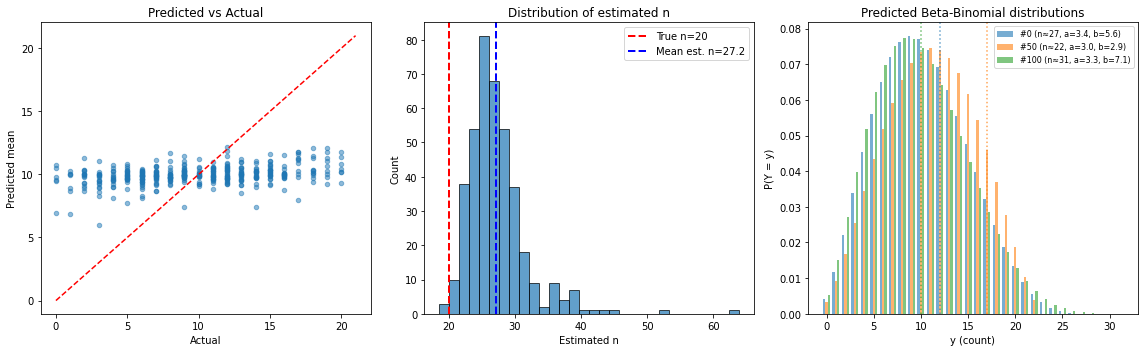

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [0, max(Y_test.max(), Y_pred.max()) + 1]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted mean")
ax.set_title("Predicted vs Actual")

# Middle: distribution of estimated n
ax = axes[1]
ax.hist(dists.n, bins=30, alpha=0.7, edgecolor="black")
ax.axvline(TRUE_N, color="r", linestyle="--", linewidth=2, label=f"True n={TRUE_N}")
ax.axvline(np.mean(dists.n), color="blue", linestyle="--", linewidth=2,
           label=f"Mean est. n={np.mean(dists.n):.1f}")
ax.set_xlabel("Estimated n")
ax.set_ylabel("Count")
ax.set_title("Distribution of estimated n")
ax.legend()

# Right: predicted PMFs for 3 test samples
ax = axes[2]
for idx in [0, 50, 100]:
    a_i = dists.alpha[idx]
    b_i = dists.beta[idx]
    n_i = int(np.round(dists.n[idx]))
    k = np.arange(0, n_i + 1)
    pmf = scipy.stats.betabinom.pmf(k, n_i, a_i, b_i)
    offset = 0.25 * [0, 50, 100].index(idx) - 0.25
    ax.bar(k + offset, pmf, width=0.25, alpha=0.6,
           label=f"#{idx} (n\u2248{n_i}, a={a_i:.1f}, b={b_i:.1f})")
    ax.axvline(Y_test[idx], color=f"C{[0, 50, 100].index(idx)}",
               linestyle=":", alpha=0.7)
ax.set_xlabel("y (count)")
ax.set_ylabel("P(Y = y)")
ax.set_title("Predicted Beta-Binomial distributions")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## When to use BetaBinomialEstN vs BetaBinomial

| Scenario | Use |
|----------|-----|
| `n` is known (e.g., 20 trials per batch) | `BetaBinomial` with fixed `n` |
| `n` is unknown, only counts observed | `BetaBinomialEstN` |
| `n` varies per sample but is observed | `BetaBinomial` with per-sample `n` via subclass |

**Fixed n is always preferred when available** — it reduces the parameter
space from 3 to 2, making optimization faster and more stable. Estimating
`n` from count data is inherently difficult because many `(n, p)`
combinations produce similar count distributions.